In [ ]:
# Loading libraries
import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

import datetime as dt
from datetime import time
from datetime import timedelta

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading datasets
train_df = pd.read_csv("/content/drive/MyDrive/CFG_Project/fraudTrain.csv", parse_dates=["trans_date_trans_time"])
test_df = pd.read_csv("/content/drive/MyDrive/CFG_Project/fraudTest.csv", parse_dates=["trans_date_trans_time"])

In [ ]:
# merging pre-split training and test datasets into one dataframe
df = train_df.append(test_df, ignore_index=True)

In [ ]:
#Removing irrelevant variables

irrelevantVar_list = ['Unnamed: 0',
                      "first",
                      "last", 
                      "street", 
                      "zip",
                      "lat",
                      "job",
                      "long",
                      "cc_num", 
                      "trans_num", 
                      "city",
                      "merchant",
                      "merch_lat",
                      "merch_long"]

df.drop(irrelevantVar_list, axis=1, inplace=True)

In [ ]:
# Using the code developed by Juliana to transform the date of birth column into numeric age
yearCharacters = 4
currentYear = int(dt.datetime.now().strftime("%Y"))

df["dob"] = currentYear - df["dob"].str[:yearCharacters].astype(int)

In [ ]:
# Defining the feature columns that I will be feeding to the model 

feature_cols = ['dob', 'category', 'amt', 'gender', 'state', 'city_pop', 'unix_time']

In [ ]:
# Defining the input variables X as the feature columns and the target variable y as the label to predict
# This time I will not split the dataset into train and test since this procedure is irrelevant when applying cross-validation methods

X = df[feature_cols] # Features
y = df.is_fraud # Target variable

I first experimented with KFold, but obtained poor results. The logistic regression model continued to show issues with overfitting despite multiple experiments with the n_splits parameter. I kept increasing the number of splits until 200, but the performance metrics were not affected by these changes and the processing time kept getting longer.

After consulting the documentation further, I realised that StratifiedKFold was more appropriate for this dataset. This is because it creates subsets of the original dataset that preserve the same minority class:majority class ratio. This is extremely important in our case, since we are hoping to use cross-validation to handle overfitting issues caused by the unbalanced nature of the dataset. After experimenting with StratifiedKFold I continued to obtain consistently poor performance metrics, the logistic regression model kept showing signs of overfitting. 

Finally, I decided to attempt RepeatedStratifiedKFold to introduce the n_repeats parameter.

In [ ]:
# Preparing the cross-validation procedure

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=30, random_state=None)

In [ ]:
# Begin pre-processing by applying OneHotEncoder to categoric features
column_trans = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                        ['category', 'gender', 'state']), 
                                       remainder='passthrough')

In [ ]:
# Create model and pre-processing pipeline
model = LogisticRegression()
pipe = make_pipeline(column_trans, model)

In [ ]:
# Here I am specifying that the model should be fit according to the pre-processing pipeline

LR_model = pipe.fit(X, y)

In [ ]:
# evaluate model
scores = cross_val_score(LR_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [ ]:
y_pred = LR_model.predict(X)

In [ ]:
# Reporting performance

print("Accuracy:",metrics.accuracy_score(y, y_pred))
print("Precision:",metrics.precision_score(y, y_pred))
print("Recall:",metrics.recall_score(y, y_pred))

Accuracy: 0.9947899852839083


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0


In [ ]:
cnf_matrix = metrics.confusion_matrix(y, y_pred)
cnf_matrix

array([[1842743,       0],
       [   9651,       0]])

Text(0.5, 257.44, 'Predicted label')

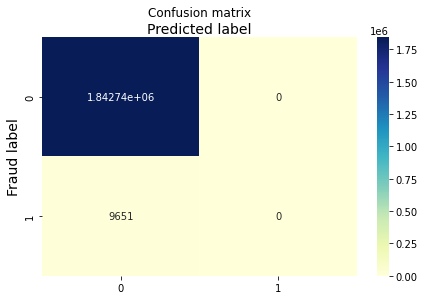

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Fraud label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)

After obtaining poor results in applying cross-validation to solve the overfitting issue, I decided to test it again within a cost-sensitive learning framework. This technique attempts to prevent overfitting by associating different costs to incorrectly predicting the majority class and the minority class. More specifically, it establishes mislabelling the minority class as a more costly action compared to mislabelling the majority class. This is exactly what we want, since an effective anti-fraud predictive model needs to be extremely accurate in identifying potentially fraudulent transactions, or the minority class, over the genuine ones.  

In [ ]:
# Here I am defining how the model should weight the different classes. I have calculated the ratio of minority:majority class
# by diving the total number of fraudulent transactions by the total number of genuine transactions present in the dataset.
# I am also redefining the model and pre-processing pipeline to more easily keep track of the modelling flow.

weights = {0:0.05, 1:1.0}
model = LogisticRegression(solver='lbfgs', class_weight='balanced')
pipe = make_pipeline(column_trans, model)

In [ ]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
t_model = pipe.fit(X, y)

In [ ]:
# evaluate model
scores = cross_val_score(t_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.553


In [ ]:
new_y_pred = t_model.predict(X)

In [ ]:
# Reporting performance

print("Accuracy:",metrics.accuracy_score(y, new_y_pred))
print("Precision:",metrics.precision_score(y, new_y_pred))
print("Recall:",metrics.recall_score(y, new_y_pred))

Accuracy: 0.9947899852839083


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0


In conclusion, employing cross validation techniques has not revealed any promising path forward to successfully prevent the logistic regression model from overfitting. It appears that the most successful model in predicting fraudulent transactions is the decision tree model associated with Juliana's pre-processing protocol  